# RAMP on predicting cyclist traffic in Paris

Authors: *Roman Yurchak (Symerio)*; also partially inspired by the air_passengers starting kit.


# Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

#### Data info and objective:
- We have 1 year data from 09/2020 to 08/09/2021
- We want to predict the bike_count for each of the counters We have 30 locations and 56 counter sites (some containing 2 and some containing 1). So we need to do a total of 56 time series predictions for each counter. The predictions need to be done for a specified time interval.
- We will actually not be able to test with out-of-sample data because we will never have access to it. We have to train the model using the data we have.
- To use time series, I need to learn to train cross-sectional time-series models. Our predictions Y need to be matrix of shape (n x k) where n is the number of data points and k is the number of bike counters (56). This is important because we plan to use lagged variables in the predictions. If we have all Y in a single vector, we wouldn't be able to do this.RK


##### Models:
- Random forest: Use bootstrapping with random forest to sample from data, look at what it is. Also, there is a feature which stops using every feature on each parameter. Look it up!

##### Questions:
- We also need the external data for the testing set predictions? How will we get it??

In [92]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import requests


# Loading the data with pandas

First, download the data files,
 - [train.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/train.parquet)
 - [test.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/test.parquet)

and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [93]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [94]:
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


We can check general information about different columns,

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   coordinates                455163 non-null  category      
 8   counter_technical_id       455163 non-null  category      
 9   latitude                   455163 non-null  float64       
 10  longitude                  455163 non-null  float64       
 11  log_bike_count             455163 non-null  floa

and in particular the number of unique entries in each column,

In [96]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    977
date                         8230
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                977
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations,

In [97]:
data.groupby(["site_name", "counter_name"])["bike_count"].sum().sort_values(
    ascending=False
).head(10).to_frame()

,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1809231.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1406900.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1357868.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1036575.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,914089.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,888717.0
Quai d'Orsay,Quai d'Orsay E-O,849724.0
Totem Cours la Reine,Totem Cours la Reine O-E,806149.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,806071.0


$\textit{Here, I will check how many counter names there are by site name}$

In [98]:
#data[["site_name","counter_name"]].groupby("site_name").count()
data[["site_name","counter_name"]].groupby("site_name").nunique().sum()

counter_name    56
dtype: int64

$\textit{There are 2 counters if the counters function in 2 ways, 1 counter if it functions in one way}$

Plot the counter counts after summing 2 way counts

<AxesSubplot:xlabel='site_name'>

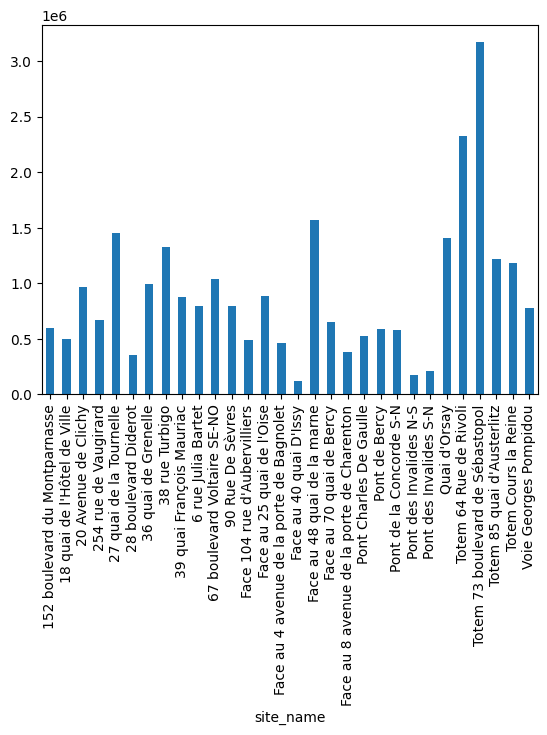

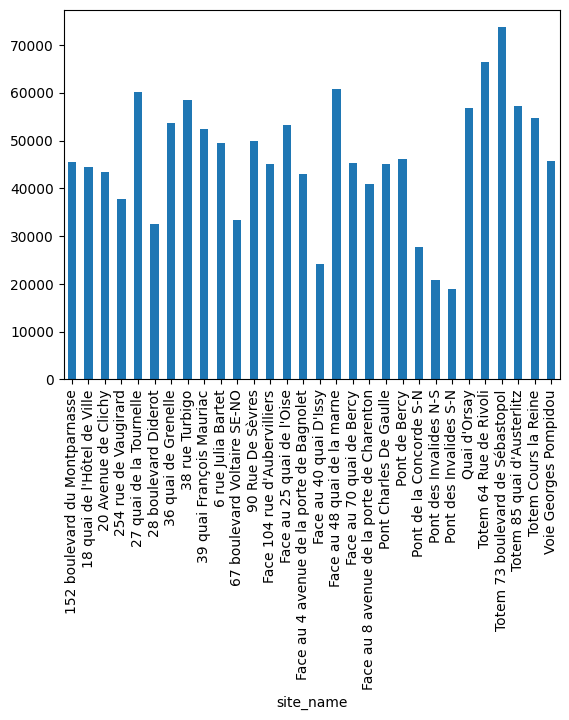

In [99]:
bike_counts = data[["site_name", "bike_count", "log_bike_count"]].groupby("site_name").sum()

bike_counts.bike_count.plot(kind="bar")
plt.figure()
bike_counts.log_bike_count.plot(kind="bar")


# Webscraping external data

In [100]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [101]:
df_weather = pd.read_csv("external_data.csv")
df_weather['date'] = pd.to_datetime(df_weather.date)
df_weather.drop(df_weather.columns[0], axis=1, inplace=True)
df_weather.head()

,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1
0,2020-09-01 23:00:00,14.9,NNE,5.6,63.0,2.995732,0,1019.1
1,2020-09-01 22:00:00,15.2,NNE,5.6,59.0,2.995732,0,1019.0
2,2020-09-01 21:00:00,16.4,NE,7.4,52.0,2.995732,0,1018.9
3,2020-09-01 20:00:00,17.1,NNE,7.4,49.0,2.995732,0,1018.5
4,2020-09-01 19:00:00,18.5,NNE,5.6,46.0,2.995732,0,1017.9


In [102]:
import datetime as dt
train_dates = X_train.date.dt.date.unique()
test_dates = X_test.date.dt.date.unique()
dates = np.unique(np.append(train_dates, test_dates))
df_weather = pd.DataFrame()
sunshine_time = pd.Series(index=dates, dtype="object")
missing_dates = []

for date in dates:
    
    try:
        _, df_hour, df_day  = pd.read_csv("external_data.csv")
    except:
        missing_dates.append(date)
        continue
    
    df_hour.insert(0, ("Heure UTC1", "date"), date)
    date = pd.to_datetime(df_hour["Heure UTC1", "date"])
    time = pd.to_datetime(df_hour["Heure UTC1", "Heure UTC1"], format="%H:%M") - dt.datetime(1900,1,1)
    df_hour.drop(columns=df_hour.columns[0:2], inplace=True)
    df_hour.insert(0, "Datetime", date+time)
    
    #Total time of sunshine in 24 hour day
    sunshine_time.loc[date] = df_day.loc[0, "Ensoleillement4 [h]"][0]
       
    df_weather = pd.concat([df_weather, df_hour], ignore_index=True)
    
sunshine_time = pd.to_datetime(sunshine_time, format = "%H h %M min") - dt.datetime(1900,1,1)

In [57]:
df_weather.head(10)

""


### Information about columns of data

- Temperature --> only keeping 2m. is enough. It is the temperature measured 2 meters above the ground
- Vent (wind) --> 
    - Dir.2 is the direction of the wind. Convert it to dummies and keep it. 
    - Vit. is the speed of the wind during measurement
    - Raf.3 is the maximum speed. Probably better to drop this
- Humidity --> keep as is, convert to float
- Pressure --> Seperate the 2 different measures, keep both since they seem uncorrelated
    - One is in terms of hour but the hour value is all equal, so we can keep it
- Visibility --> Keep as is
- Nebu --> Cloud coverage, Nan column, we drop it
- Préc.5 [mm] --> Amount of rain binned. Turn into int categorical. Bin it.
- Cond. --> Some comments about the weather. Exists in very few columns and is in french. So we drop it

In [23]:
col_names = ["Datetime", "Temperature (C)", "wind_temp", "dew_point_temp", "wind_dir", "wind_speed",
            "avg_wind_speed", "max_wind_speed", "Humidity", "Pressure", "Visibility", "Cloudiness",
            "Precipitation", "Comment"]
df_weather.columns = col_names
df_weather.set_index("Datetime", inplace=True)
df_weather.head()

ValueError: Length mismatch: Expected axis has 9 elements, new values have 14 elements

##### Temperature columns

0.47359747149791165


,wind_temp,Temperature (C)
wind_temp,1.000000,0.996703
Temperature (C),0.996703,1.000000


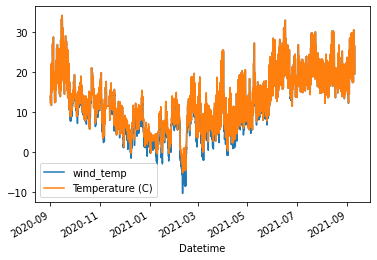

In [281]:
df_weather[["wind_temp", "Temperature (C)"]].plot()
print((df_weather["Temperature (C)"] - df_weather.wind_temp).mean())
df_weather[["wind_temp", "Temperature (C)"]].corr()

Wind temperature is not worth keeping because of high correlation with regular temperature

In [282]:
df_weather.drop(columns=["wind_temp", "dew_point_temp"], inplace=True)

<AxesSubplot:>

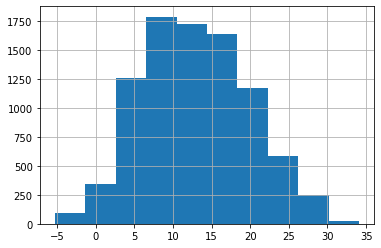

In [283]:
df_weather["Temperature (C)"].hist()

##### Wind columns

In [284]:
df_weather[["wind_dir", "wind_speed", "avg_wind_speed", "max_wind_speed"]].head()

,wind_dir,wind_speed,avg_wind_speed,max_wind_speed
Datetime,,,,
2020-09-01 23:00:00,NNE,5.6,--,11.1
2020-09-01 22:00:00,NNE,5.6,--,16.7
2020-09-01 21:00:00,NE,7.4,--,14.8
2020-09-01 20:00:00,NNE,7.4,--,16.7
2020-09-01 19:00:00,NNE,5.6,--,13.0


In [285]:
# One-hot encode wind direction 
from sklearn.preprocessing import OneHotEncoder

df_weather.wind_dir.value_counts()
enc = OneHotEncoder()
winddir_dummies = enc.fit_transform(df_weather["wind_dir"].to_numpy().reshape(-1,1))
winddir_dummies.shape

#drop avg and max
df_weather.drop(columns=["avg_wind_speed", "max_wind_speed"], inplace=True)

##### Humidity Column

In [286]:
hum = df_weather.Humidity
print("Nan value count:",hum[hum == "--"].count())

#Replace nan with the previous value
hum.replace("--", method="ffill", inplace=True)
print("Nan value count after replacement:",hum[hum == "--"].count())

Nan value count: 42
Nan value count after replacement: 0


<AxesSubplot:>

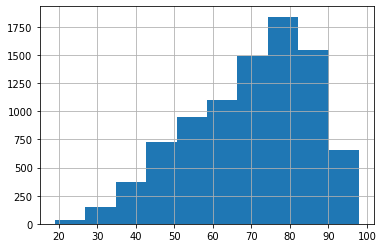

In [287]:
df_weather["Humidity"] = hum.astype("float64")
df_weather.Humidity.hist()

In [288]:
df_weather.drop(columns=["Cloudiness", "Comment"], inplace=True)

##### Pressure column

In [289]:
pr = df_weather["Pressure"]

pr = [i.rstrip("h)").split("(") for i in pr]

df_weather["pressure1"] = pd.Series([float(i[0]) for i in pr], index=df_weather.index)
df_weather["pressure2"] = pd.Series([float(i[1].rstrip("/3")) for i in pr], index=df_weather.index)

df_weather.drop(columns=["Pressure"], inplace=True)

df_weather.head()

,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1,pressure2
Datetime,,,,,,,,
2020-09-01 23:00:00,14.9,NNE,5.6,63.0,20.0,0/1h,1019.1,0.6
2020-09-01 22:00:00,15.2,NNE,5.6,59.0,20.0,0/1h,1019.0,1.0
2020-09-01 21:00:00,16.4,NE,7.4,52.0,20.0,0/3h,1018.9,1.2
2020-09-01 20:00:00,17.1,NNE,7.4,49.0,20.0,0/1h,1018.5,0.8
2020-09-01 19:00:00,18.5,NNE,5.6,46.0,20.0,0/1h,1017.9,0.4


,pressure1,pressure2
pressure1,1.00000,0.06839
pressure2,0.06839,1.00000


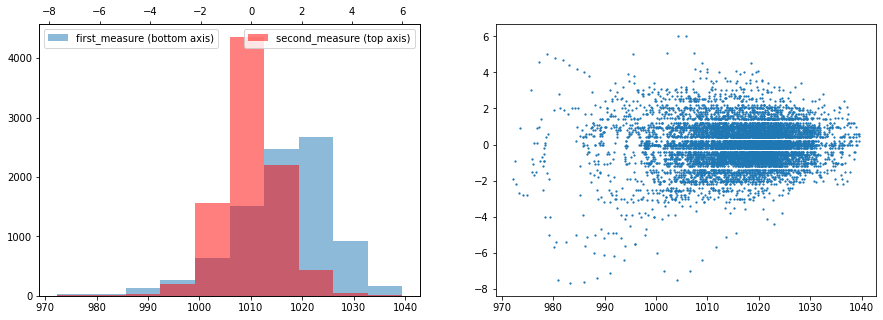

In [290]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0].hist(df_weather["pressure1"], alpha=0.5, label="first_measure (bottom axis)")
ax[0].legend(loc=2)
ax2 = ax[0].twiny()
ax2.hist(df_weather["pressure2"], alpha=0.5, color="r", label="second_measure (top axis)")
ax2.legend(loc=1)
ax[1].scatter(df_weather["pressure1"], df_weather["pressure2"], s=1.5)
display(df_weather[["pressure1", "pressure2"]].corr())


We will only use the first measure, so drop the second

In [291]:
df_weather.drop("pressure2", axis=1, inplace=True)

First, we seperated the two different measures of pressure, then converted them to floats and plotted them. The values are not correlated so we can use both for our analysis.

##### Precipitation Column

- h represents the hour 
- /1h means the rain that fell during 1 hour. So it might make sense to divide the numerator by the denominator
- Trace rainfall is defined as rainfall under 0.2 mm (or 0.05 in) which cannot be. measured by conventional types

- Operation logic for the column:
    - If there are multiple measures, take the one with the least hour interval, which is the first one

In [292]:
df_weather.Precipitation.value_counts()

0/1h                         4945
0/3h                         1105
0/3h 0/6h                     496
trace/1h                      412
0.2/1h                        204
                             ... 
7/3h 12/12h                     1
trace/3h 0.2/12h 11.1/24h       1
trace/3h 2/12h 14.3/24h         1
0/3h 0.8/12h                    1
0/3h 3/12h 2.6/24h              1
Name: Precipitation, Length: 293, dtype: int64

In [293]:
df_weather.Precipitation[df_weather.Precipitation == "trace/3h 0.2/12h 11.1/24h"] #This is worth checking over

Datetime
2020-12-28 06:00:00    trace/3h 0.2/12h 11.1/24h
Name: Precipitation, dtype: object

In [294]:
prec = df_weather.Precipitation.copy()

#Remove any extra data about longer time intervals
prec = pd.Series([i[0] for i in prec.str.split(" ")],
                 index=prec.index)

#Split  numerator and denominator and remove "h"
prec = pd.DataFrame(prec.str.split("/").to_list(), 
                    columns=["num", "den"],
                    index=prec.index)
prec["den"] = prec.den.str.strip("h")
prec["den"].value_counts()


1    5928
3    2929
Name: den, dtype: int64

In [295]:
prec.num.value_counts().index

Index(['0', 'trace', '0.2', '0.4', '1', '0.6', '2', '0.8', '3', '4', '6', '5',
       '9', '7', '16', '8', '10', '--', '11', '0.9', '0.7', '28', '13', '18',
       '12'],
      dtype='object')

- We know that trace is data very small. It is a safe assumption to replace it with 0.05 __?__
- We also see that we must deal with "--" in the column

In [296]:
prec[prec.num == "--"] 

,num,den
Datetime,,
2021-02-16 17:00:00,--,None
2021-04-20 10:00:00,--,None


There are 2 empty frames, we can replace them with the previous row value for both numerator and denominator by converting
them into nan values


In [297]:
nan_ind = prec[prec.num == "--"].index #indices to replace
nan_ind
prec.loc[nan_ind] = np.nan
display(prec.loc[nan_ind])
prec.fillna(method="ffill", inplace=True)

,num,den
Datetime,,
2021-02-16 17:00:00,NaN,NaN
2021-04-20 10:00:00,NaN,NaN


In [298]:
#Convert trace into 0.05
prec.replace("trace", 0.001, inplace=True)
prec = prec.astype("float64")

<AxesSubplot:>

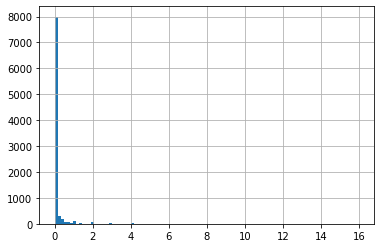

In [299]:
#Lastly, divide the numerator of the 3 hour denominator columns with 3 to obtain rain for 1 hour
prec = pd.Series(np.where(prec.den == 3., prec.num/3, prec.num),
                index=prec.index)
prec.hist(bins=100)

The value are very uneven with a concentration on zero values, we will bin the variables.
- Categories
    - 0 --> x = 0
    - 1 --> trace (value it as e-3)
    - 2 --> 0.01 < x < 1
    - 3 --> 1 < x 
    
We can also create a dummy and try that

In [300]:
(prec* 1e3).value_counts()

0.000000        7129
1.000000         412
0.333333         246
200.000000       204
66.666667        141
400.000000       101
1000.000000       92
333.333333        66
133.333333        64
600.000000        64
666.666667        61
2000.000000       54
800.000000        50
200.000000        45
266.666667        38
3000.000000       28
1333.333333       17
4000.000000       14
1666.666667        7
2333.333333        5
5000.000000        4
6000.000000        4
5333.333333        2
8000.000000        1
2666.666667        1
3333.333333        1
300.000000         1
700.000000         1
9333.333333        1
3666.666667        1
4333.333333        1
16000.000000       1
10000.000000       1
11000.000000       1
dtype: int64

<AxesSubplot:>

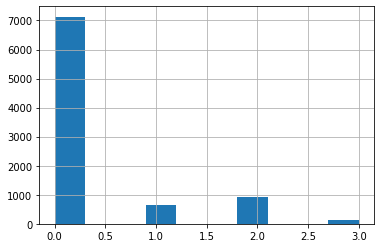

In [301]:
prec_binned = pd.cut(prec*1e3, [-0.01, 0, 1, 1000, np.inf],
                     labels=[0, 1, 2, 3])
prec_binned.hist()

In [302]:
df_weather["Precipitation"] = prec_binned

In [36]:
df_weather.head()

,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1
0,2020-09-01 23:00:00,14.9,NNE,5.6,63.0,2.995732,0,1019.1
1,2020-09-01 22:00:00,15.2,NNE,5.6,59.0,2.995732,0,1019.0
2,2020-09-01 21:00:00,16.4,NE,7.4,52.0,2.995732,0,1018.9
3,2020-09-01 20:00:00,17.1,NNE,7.4,49.0,2.995732,0,1018.5
4,2020-09-01 19:00:00,18.5,NNE,5.6,46.0,2.995732,0,1017.9


In [303]:
df_weather.head()

,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1
Datetime,,,,,,,
2020-09-01 23:00:00,14.9,NNE,5.6,63.0,20.0,0,1019.1
2020-09-01 22:00:00,15.2,NNE,5.6,59.0,20.0,0,1019.0
2020-09-01 21:00:00,16.4,NE,7.4,52.0,20.0,0,1018.9
2020-09-01 20:00:00,17.1,NNE,7.4,49.0,20.0,0,1018.5
2020-09-01 19:00:00,18.5,NNE,5.6,46.0,20.0,0,1017.9


array([[<AxesSubplot:title={'center':'Temperature (C)'}>,
        <AxesSubplot:title={'center':'wind_speed'}>],
       [<AxesSubplot:title={'center':'Humidity'}>,
        <AxesSubplot:title={'center':'Visibility'}>],
       [<AxesSubplot:title={'center':'pressure1'}>, <AxesSubplot:>]],
      dtype=object)

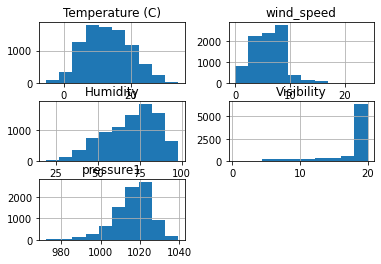

In [304]:
df_weather.hist()

Take the log of visibility to make values more normal

<AxesSubplot:>

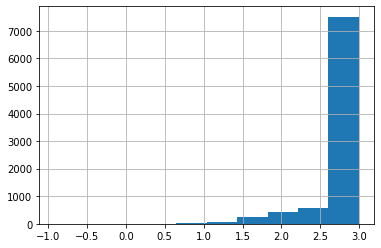

In [305]:
df_weather["Visibility"] = np.log(df_weather.Visibility)
df_weather.Visibility.hist()

##### Data is ready to deploy

# External data csv: 

Working with the external data provided by the project by default

- We can try PCA to shrink the columns of the data

### External Sources:
- https://www.historique-meteo.net/france/ile-de-france/paris/2020/
    - export-paris 2020, export-paris 2021
- https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/table/?sort=date
    - donnees-synop-essentielles-omm
    
   

In [ ]:
df_ext = pd.read_csv("submissions/external_data/external_data.csv")
df_ext.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_ext, title="External data given by professors", minimal=True)
profile.to_file("given_external_data.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Dell\AppData\Roaming\Python\Python39\site-packages\pandas_profiling\model\pandas\summary_pandas.py:80: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  args = [(name, series) for name, series in df.iteritems()]
C:\Users\Dell\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Dell\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Dell\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Dell\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#Format datetime, and set datetime as index to match with other data

df_ext["date"] = pd.to_datetime(df_ext.date, format="%Y-%m-%d %H:%M:%S")
df_ext.date

#drop cols with all nan values
all_nans = df_num_stats[df_num_stats.relative_nan_vals > 0.99].index
df_ext.drop(columns=all_nans, inplace=True)


In [ ]:
#df_ext[np.isclose(df_ext,0)].sum()

df_num = df_ext.select_dtypes(include=np.number)


df_num_stats = pd.DataFrame({
    "zero_vals": df_num[df_num == 0].count(),
    "nan_vals": df_num.isna().sum(),
    "relative_nan_vals": (df_num.isna().sum() / len(df_num))
})

df_num_stats

,zero_vals,nan_vals,relative_nan_vals
numer_sta,0,0,0.000000
pmer,0,0,0.000000
tend,139,0,0.000000
cod_tend,227,0,0.000000
dd,46,0,0.000000
ff,46,0,0.000000
t,0,0,0.000000
td,0,0,0.000000
u,0,0,0.000000
vv,0,0,0.000000


- Drop nan columns if more than 30% of data is missing, otherwise, use scipy interpolate
- For columns with no zero values and many nan values, replace nans with 0 because Nans probably imply that it was not a cloudy day. We know this from seeing that there are no values with 0.
- __Figure out what to do with columns containing many nans and also zeros__

In [ ]:
#find columns with less than 10 values for zero and more than 30% values for nan
dealt_cols = []

to_replace = df_num_stats[(df_num_stats.zero_vals < 10)&(df_num_stats.relative_nan_vals > 0.3)].index
df_ext[to_replace] = df_ext[to_replace].fillna(0)


#concatenate all columns that have been dealt with
dealt_cols = dealt_cols + [i for i in to_replace]
dealt_cols = pd.Series(dealt_cols).unique()

In [ ]:
#Redo the stats to see the status
df_num = df_ext.select_dtypes(include=np.number)


df_num_stats = pd.DataFrame({
    "zero_vals": df_num[df_num == 0].count(),
    "nan_vals": df_num.isna().sum(),
    "relative_nan_vals": (df_num.isna().sum() / len(df_num))
})

df_num_stats

,zero_vals,nan_vals,relative_nan_vals
numer_sta,0,0,0.000000
pmer,0,0,0.000000
tend,139,0,0.000000
cod_tend,227,0,0.000000
dd,46,0,0.000000
ff,46,0,0.000000
t,0,0,0.000000
td,0,0,0.000000
u,0,0,0.000000
vv,0,0,0.000000


In [ ]:
remaining_cols = df_ext.columns.drop(to_replace)
df_num_stats.loc[remaining_cols.drop("date")]

,zero_vals,nan_vals,relative_nan_vals
numer_sta,0,0,0.000000
pmer,0,0,0.000000
tend,139,0,0.000000
cod_tend,227,0,0.000000
dd,46,0,0.000000
ff,46,0,0.000000
t,0,0,0.000000
td,0,0,0.000000
u,0,0,0.000000
vv,0,0,0.000000


In [ ]:
#exploration of ctype

d = df_ext[["ctype1","ctype2","ctype3","ctype4"]].copy()

d.dropna(axis=0, thresh=2, inplace=True)
d[d.max(axis=1) == d.ctype3]

#ctypes nan vals can be interpreted as zero
df_ext[d.columns] = df_ext[d.columns].fillna(0)

In [ ]:
remaining_cols = remaining_cols.drop(d.columns)
remaining_cols = remaining_cols.drop

Index(['numer_sta', 'date', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td',
       'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'pres',
       'tend24', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige', 'ssfrai',
       'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'nnuage1', 'hnuage1'],
      dtype='object')

# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [15]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

Note that in this RAMP problem we consider only the 30 most frequented counting sites, to limit data size.


Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points,

<AxesSubplot:xlabel='date'>

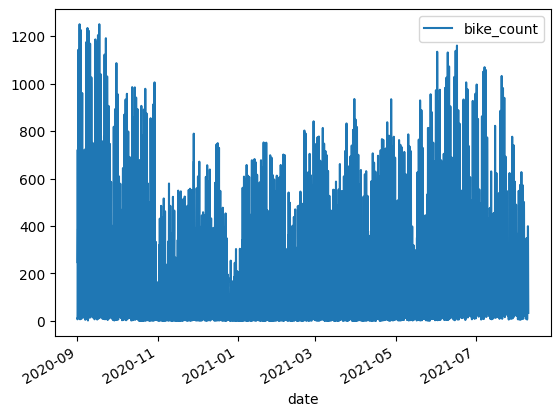

In [16]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")

Instead we aggregate the data, for instance, by week to have a clearer overall picture,

<AxesSubplot:xlabel='date'>

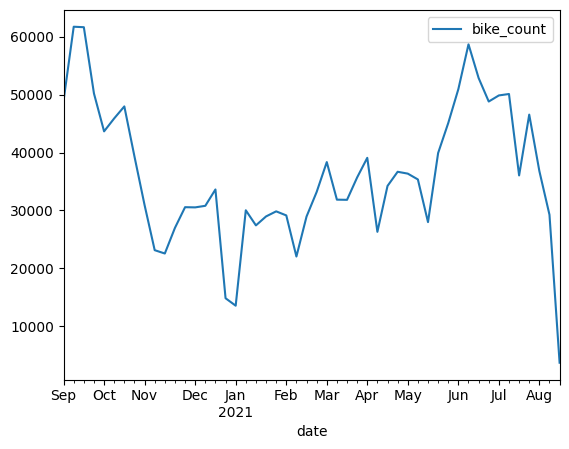

In [17]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]].sum().plot()

While at the same time, we can zoom on a week in particular for a more short-term visualization,

<AxesSubplot:xlabel='date'>

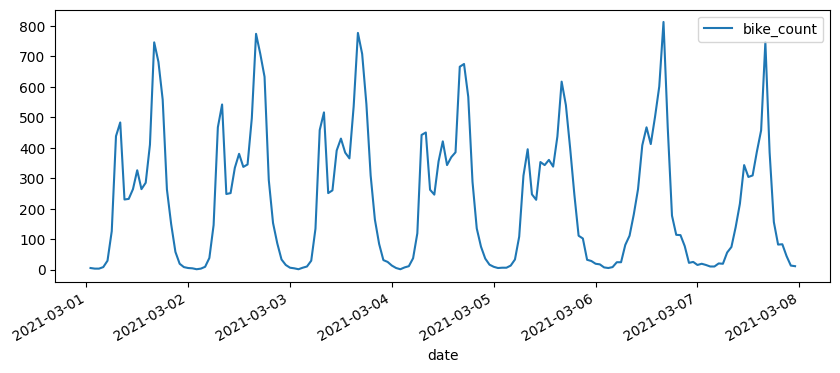

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/03/01"))
    & (data["date"] < pd.to_datetime("2021/03/08"))
)

data[mask].plot(x="date", y="bike_count", ax=ax)

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

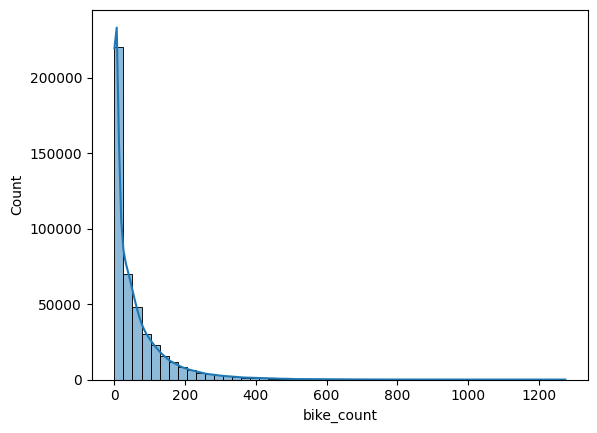

In [19]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

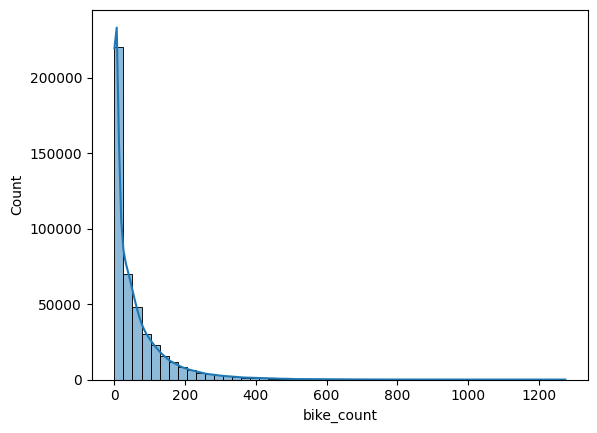
Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

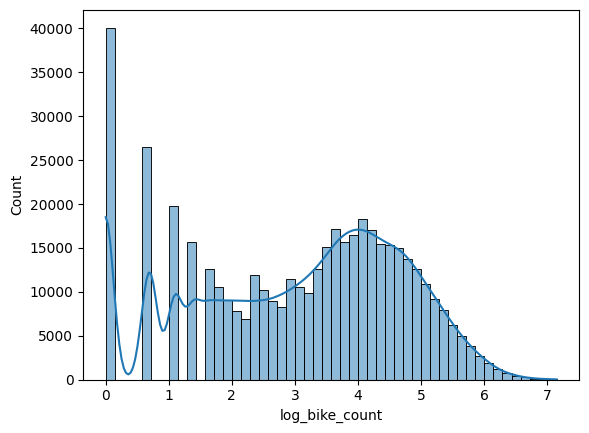

In [20]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field, 

In [77]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [78]:
data["date"].head()

48321   2020-09-01 02:00:00
48324   2020-09-01 03:00:00
48327   2020-09-01 04:00:00
48330   2020-09-01 15:00:00
48333   2020-09-01 18:00:00
Name: date, dtype: datetime64[ns]

In [79]:
_encode_dates(data[["date"]].head())

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html),

In [80]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(data[["date"]]).head()

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [25]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

enc.fit_transform(_encode_dates(data[["date"]])[["hour"]].head())

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

## Linear model

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `problem.py` of the starting kit to load the public train and test data:

In [26]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [27]:
X_train.head(2)

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233


and

In [28]:
y_train

array([1.60943791, 1.38629436, 0.        , ..., 2.48490665, 1.60943791,
       1.38629436])

Where `y` contains the `log_bike_count` variable. 

The test set is in the future as compared to the train set,

In [29]:
print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Test: n_samples={X_test.shape[0]},  {X_test["date"].min()} to {X_test["date"].max()}'
)

Train: n_samples=455163,  2020-09-01 01:00:00 to 2021-08-09 23:00:00
Test: n_samples=41608,  2021-08-10 01:00:00 to 2021-09-09 23:00:00


In [30]:
_encode_dates(X_train[["date"]]).columns.tolist()

['year', 'month', 'day', 'weekday', 'hour']

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001C796C541F0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

We then evaluate this model with the RMSE metric,

In [32]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

Train set, RMSE=0.80
Test set, RMSE=0.73


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [33]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, np.full(y_test.shape, y_test.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.68
Test set, RMSE=1.44


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations,

In [34]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

Text(0, 0.5, 'bike_count')

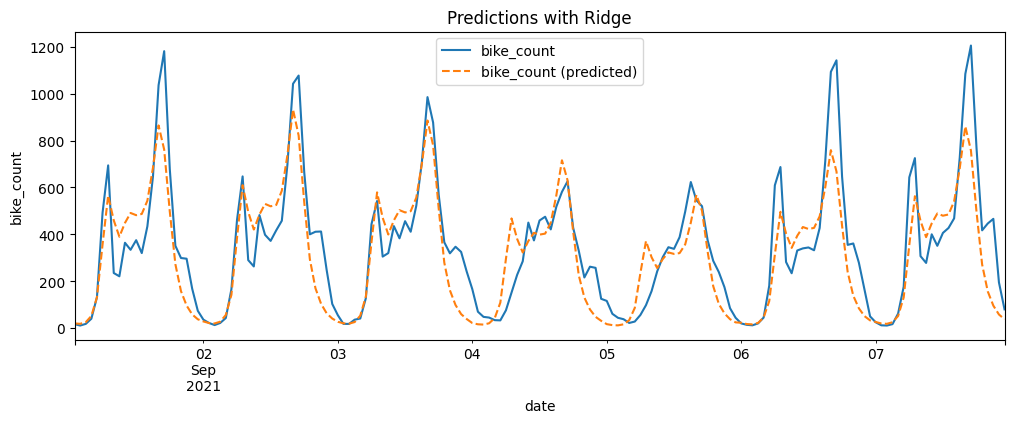

In [35]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

<AxesSubplot:xlabel='y_true', ylabel='y_pred'>

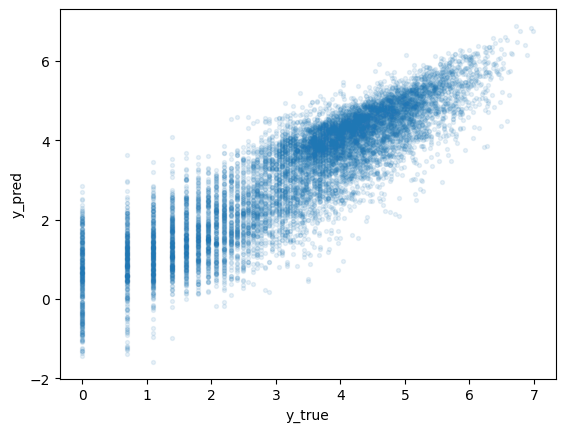

In [36]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_test, "y_pred": pipe.predict(X_test)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html),

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores, 

In [37]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.96320888 -0.87311411 -0.85383867 -0.87000263 -1.0607788  -0.97297134]
RMSE (all folds): 0.932 ± 0.0738


### Addition of the external weather data

##### Exploration of the data

- Drop irrelevant values, one-hot-encode date and wind_direction
- Figure out how to join the data from the problem.py
- There are some missing specific hours. We can either find these hours and fill them with previous values or we can drop them

In [37]:
df_weather.reset_index(inplace=True)
df_weather.rename(columns={"Datetime":"date"}, inplace=True)

In [38]:
#Check if df_weather dates are a subset of X_train dates
df_weather.index.isin(X_train.date).all()

False

In [39]:
#rows present in weather data but absent in main data
absent_indices = df_weather[~df_weather.date.isin(X_train.date)]
absent_indices

,index,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1
0,0,2020-09-01 23:00:00,14.9,NNE,5.6,63.0,2.995732,0,1019.1
1,1,2020-09-01 22:00:00,15.2,NNE,5.6,59.0,2.995732,0,1019.0
2,2,2020-09-01 21:00:00,16.4,NE,7.4,52.0,2.995732,0,1018.9
3,3,2020-09-01 20:00:00,17.1,NNE,7.4,49.0,2.995732,0,1018.5
4,4,2020-09-01 19:00:00,18.5,NNE,5.6,46.0,2.995732,0,1017.9
...,...,...,...,...,...,...,...,...,...
8851,8851,2021-09-09 04:00:00,20.3,SO,1.9,94.0,1.589235,0,1010.8
8852,8852,2021-09-09 03:00:00,20.6,SSO,3.7,93.0,1.945910,0,1011.1
8853,8853,2021-09-09 02:00:00,20.7,OSO,1.9,93.0,2.197225,0,1011.0
8854,8854,2021-09-09 01:00:00,21.1,SSO,3.7,92.0,2.079442,0,1010.7


In [ ]:
#missing dates in weather data
X_train.date[~X_train.date.isin(df_weather.date)].unique()

AttributeError: 'DataFrame' object has no attribute 'date'

In [43]:
df_weather[df_weather.date_only == dt.datetime(2020,10,23)]

AttributeError: 'DataFrame' object has no attribute 'date_only'

##### Training the model

In [44]:
#df_weather has 3 duplicate rows for some reason. Remove them
print(df_weather.date.shape, df_weather.date.unique().shape)
df_weather = df_weather.loc[~df_weather.date.duplicated(),:]

AttributeError: 'DataFrame' object has no attribute 'date'

In [84]:
#COPY THIS CELL
X_train_comb = X_train.join(df_weather.set_index("date"), on="date") 
print(X_train_comb.shape)
X_train_comb["y_train"] = y_train.copy()
X_train_comb.dropna(inplace=True)
print(X_train_comb.shape)

y_train = X_train_comb["y_train"]
X_train_comb.drop("y_train", axis=1, inplace=True)

#Do the same operations for X_test
X_test_comb = X_test.join(df_weather.set_index("date"), on="date") 
print(X_test_comb.shape)
X_test_comb["y_test"] = y_test.copy()
X_test_comb.dropna(inplace=True)
print(X_test_comb.shape)

y_test = X_test_comb["y_test"]
X_test_comb.drop("y_test", axis=1, inplace=True)
X_test_comb.shape, y_test.shape

(455163, 17)
(448861, 18)
(41608, 17)
(41384, 18)


((41384, 17), (41384,))

In [312]:
X_train_comb.shape, y_train.shape

((448861, 17), (448861,))

In [313]:
X_test.date.isin(df_weather.date)

409684    True
419698    True
95619     True
106657    True
883947    True
          ... 
792857    True
805182    True
815218    True
125979    True
135985    True
Name: date, Length: 41608, dtype: bool

(41608, 17)
(41384, 18)


((41384, 17), (41384,))

In [86]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        #("scaler", scaler, numerical_cols)
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train_comb, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001EA40555990>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir'])])),
                ('ridge', Ridge())])

In [87]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train_comb), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test_comb), squared=False):.2f}"
)

Train set, RMSE=0.80
Test set, RMSE=0.72


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations,

In [88]:
mask = (
    (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
    & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test_comb.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test_comb[mask])) - 1

Text(0, 0.5, 'bike_count')

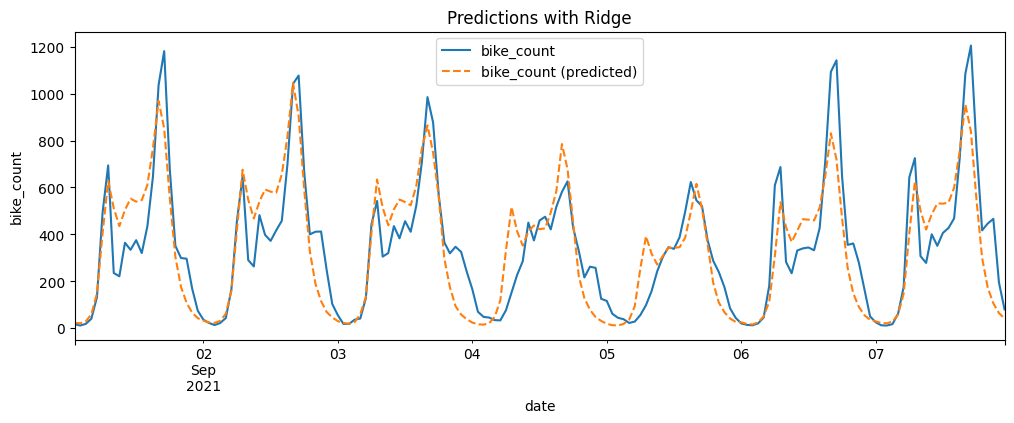

In [89]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

<AxesSubplot:xlabel='y_true', ylabel='y_pred'>

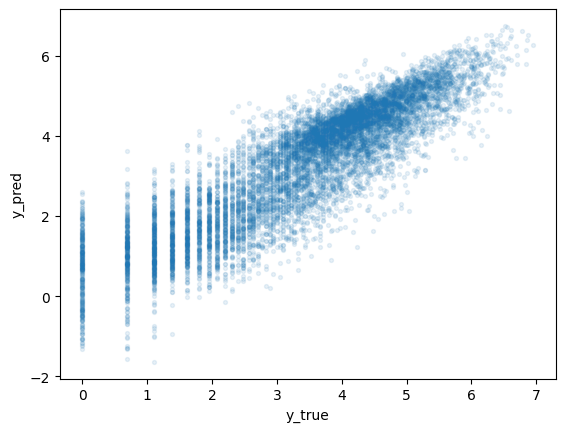

In [90]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_test, "y_pred": pipe.predict(X_test_comb)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html),

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores, 

In [91]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train_comb, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.94319934 -0.87482573 -0.8544322  -0.87397408 -1.05797229 -0.97989837]
RMSE (all folds): 0.931 ± 0.0718


In [329]:
pipe[-1].get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

## Polynomial Features Linear Regression
- Build a grid search for polynomial features.
- Does it only make sense to create polynomial features from numerical columns? Or can we use the entire dataset to create it?

In [357]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols)
    ]
)

poly_features = PolynomialFeatures()

regressor = LinearRegression()

pipe = Pipeline([("dates", date_encoder),
                 ("preprocessing", preprocessor),
                 ("poly_features", poly_features) 
                 ("regression", regressor)])
pipe.fit(X_train_comb, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x00000203D5EB2CA0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir']),
                                                 ('polynomial',
                                                  PolynomialFeatures(degree=5),
                                                  Index(['site_id', 'latitude', 'longitude', 'Tempe

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline


date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols)
    ]
)

poly_features = PolynomialFeatures()
regressor = Ridge()

pipe = Pipeline([("dates", date_encoder),
                 ("preprocessing", preprocessor),
                 ("poly_features", poly_features), 
                 ("regression", regressor)])

param_grid = {"poly_features__degree":[1,2,3,4,5]}
search = GridSearchCV(pipe, param_grid, cv=3, verbose=10)

search.fit(X_train_comb, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] START poly_features__degree=1.....................................
[CV 1/3; 1/5] END ......poly_features__degree=1;, score=0.504 total time=   1.4s
[CV 2/3; 1/5] START poly_features__degree=1.....................................
[CV 2/3; 1/5] END ......poly_features__degree=1;, score=0.696 total time=   1.1s
[CV 3/3; 1/5] START poly_features__degree=1.....................................
[CV 3/3; 1/5] END ......poly_features__degree=1;, score=0.548 total time=   1.1s
[CV 1/3; 2/5] START poly_features__degree=2.....................................
[CV 1/3; 2/5] END ......poly_features__degree=2;, score=0.652 total time=   6.1s
[CV 2/3; 2/5] START poly_features__degree=2.....................................
[CV 2/3; 2/5] END ......poly_features__degree=2;, score=0.684 total time=   6.8s
[CV 3/3; 2/5] START poly_features__degree=2.....................................
[CV 3/3; 2/5] END ......poly_features__degree=2;,

In [ ]:
print(search)

In [358]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train_comb), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test_comb), squared=False):.2f}"
)

Train set, RMSE=1.53
Test set, RMSE=1.27


In [359]:
mask = (
    (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
    & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test_comb.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test_comb[mask])) - 1

Text(0, 0.5, 'bike_count')

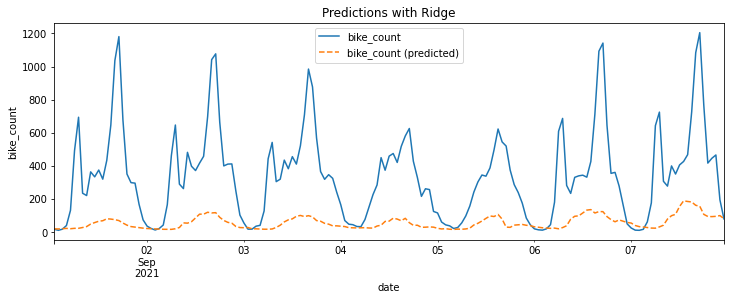

In [360]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

## _Random Forest Regression_

1. Apply a random forest regressor, while standardizing and encoding numerical and categorical data
2. Use Grid Search for our params
3. Get the best estimators out of it

In [45]:
from sklearn.ensemble import RandomForestRegressor

In [46]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)

RandomForest = RandomForestRegressor()

pipe = make_pipeline(date_encoder, preprocessor, RandomForest)
pipe.fit(X_train_comb, y_train)

NameError: name 'X_train_comb' is not defined

## XG Boosting

In [5]:
from xgboost import XGBRegressor
import xgboost as xgb

In [ ]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)

Boost = XGBRegressor()

pipe = make_pipeline(date_encoder, preprocessor, Boost)
pipe.fit(X_train_comb, y_train)

We try to find out which features are more important for us and we plot them

In [ ]:
xgb.plot_importance(pipe, ax=plt.gca())

In [ ]:
pipe[-1].get_params()

In [ ]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train_comb), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test_comb), squared=False):.2f}"
)

In [ ]:
mask = (
    (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
    & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test_comb.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test_comb[mask])) - 1

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count") 

We then plan to calculate R^2 score and MSE to find out how are model works and whether it overfits or not 